In [25]:
# Import the libraries we will be using
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [26]:
# Define the file paths for training and test data
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

# Import training and test data
train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


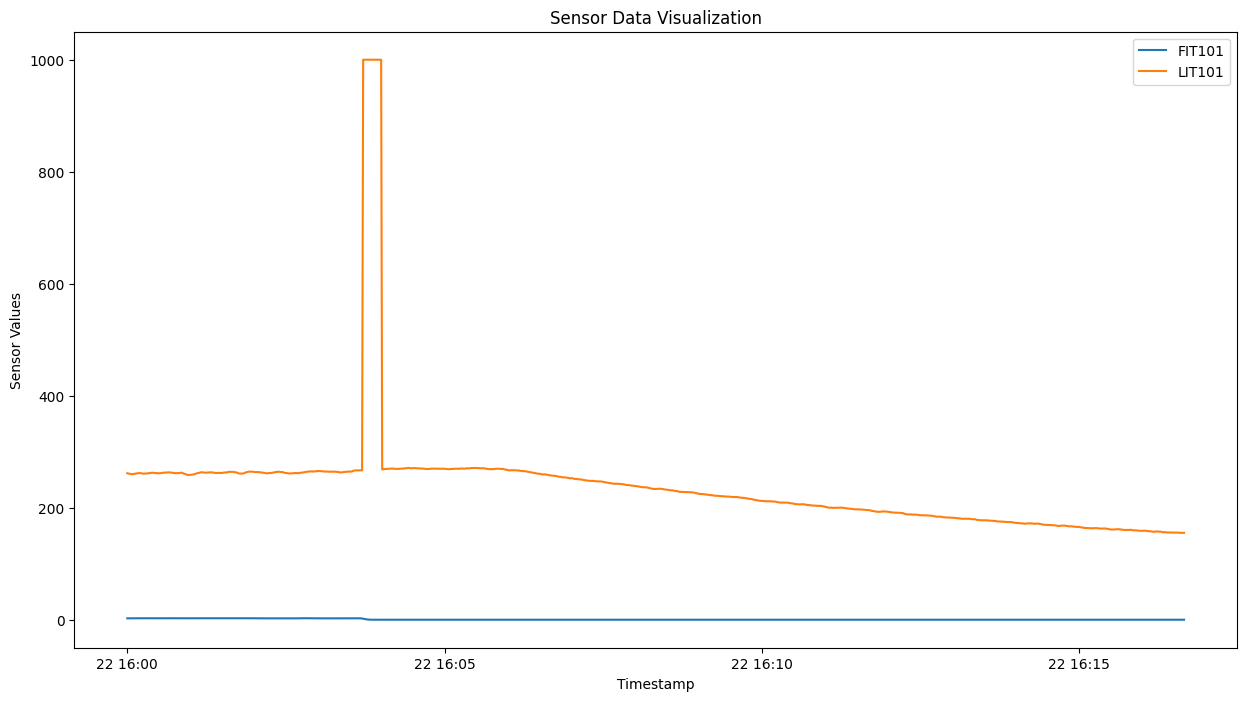

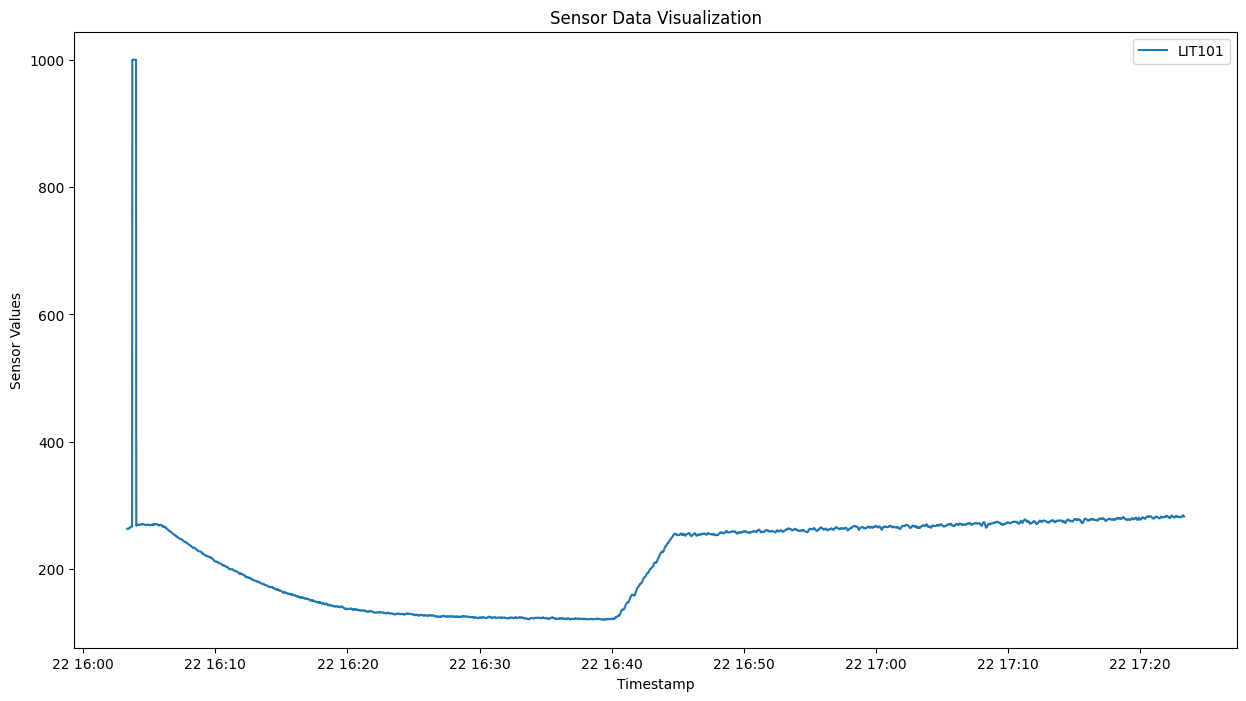

C:\Users\sorin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


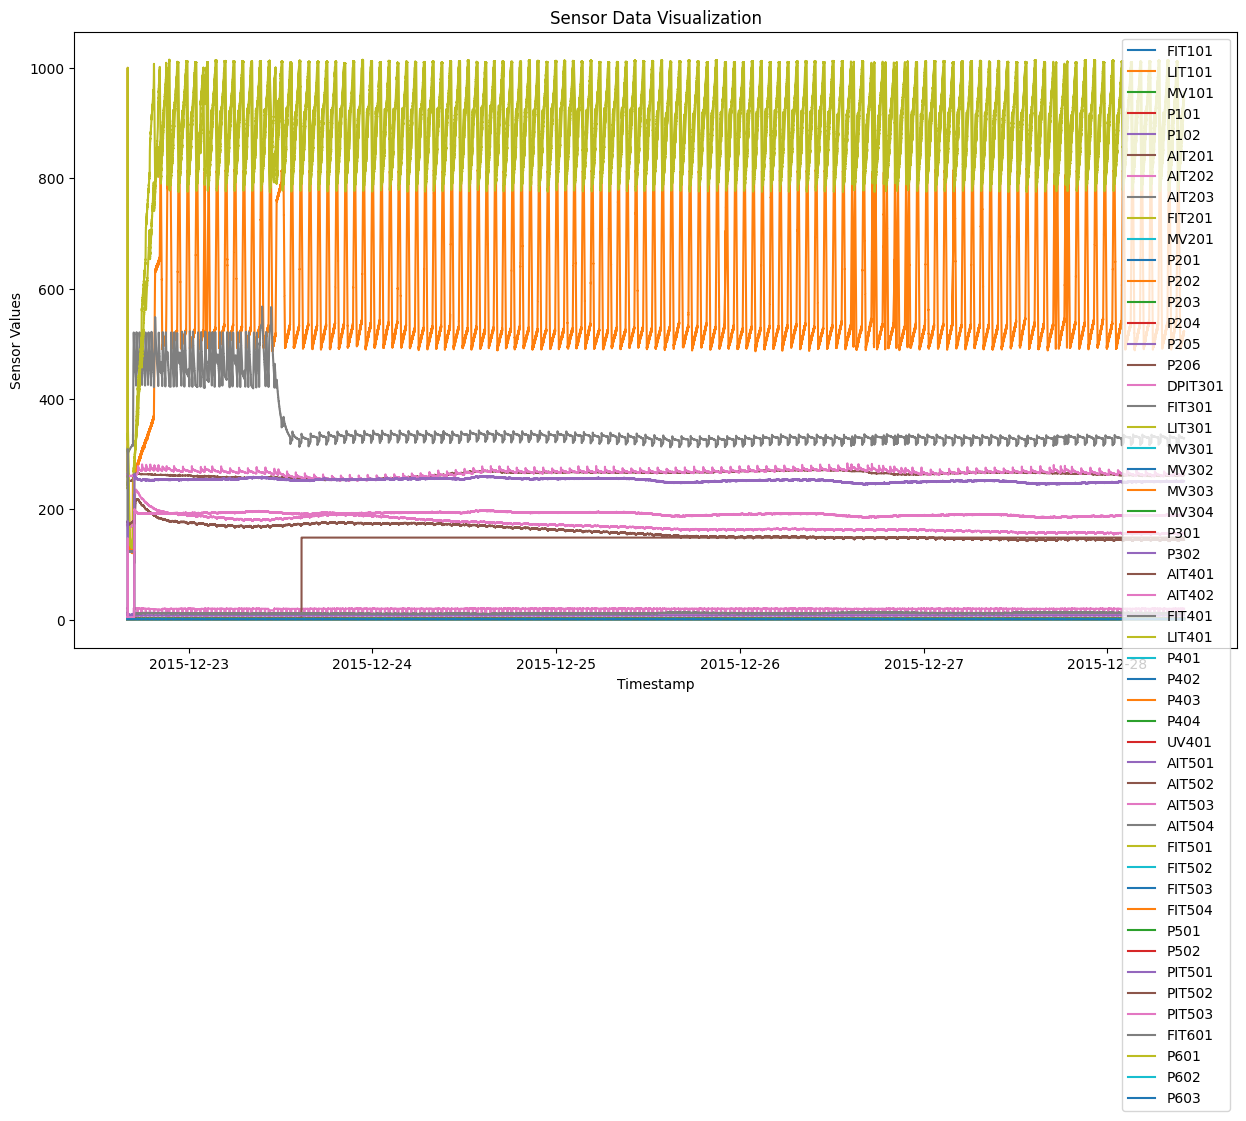

In [27]:
# Method used to visualize sensor data
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 5000), sensors=['LIT101'])
visualize_sensor_data(train_data)

The first function function takes as input a data frame and an integer that denotes the number of required eigenvalues. It should return the eigenvectors it computed from the data frame. The second function takes as input a data frame and a list of eigenvector, and it returns the projected data.

In [28]:
# PCA Algorithm for choosing the eigenvectors and eigenvalues
def principal_component_analysis(df, k):
    cov_df = np.cov(df.T)
    eig_val, eig_vec = np.linalg.eig(cov_df.T)
    indx = np.argsort(eig_val)

    eigenvectors = eig_vec[:, indx][:, ::-1]
    return eigenvectors[:, 0:k]


def apply_principal_component_analysis(df, eigenvectors):
    means = np.mean(df, axis=0)
    normalized_df = (df - means)
    projected_data = normalized_df @ eigenvectors
    return projected_data

In [29]:
# compute PCA for a data set
def pca_with_k_components(data, data_to_reduce, k = 3):
    principal_components = principal_component_analysis(data, k)
    reduced_data = apply_principal_component_analysis(data_to_reduce, principal_components)
    return principal_components, reduced_data

# reconstruct data after it has been reduced
def reconstruct_data(data, principal_components):
    return np.real(apply_principal_component_analysis(data, principal_components.T))

In [30]:
# take data and normalize it
def normalize_data(data):
    means = np.mean(data, axis=0)
    standard_dev = data.std()
    epsilon = 1e-10
    standard_dev[standard_dev == 0] = epsilon
    normalized_data = (data - means)/standard_dev
    return normalized_data

In [31]:
# take two data sets, one for which we take the principal components and the other is the one on which we want  to apply pca
def compute_principal_components_and_resulting_data_after_pca(data, data_to_reduce, k = 20, start_index1 = 0, end_index1 = 1000, start_index2 = 0, end_index2 = 1000):
    filtered_data = data.drop(["Timestamp", "Normal/Attack"],errors='ignore', axis=1)
    normalized_filtered_data = normalize_data(filtered_data)
    filtered_data_to_reduce =  data_to_reduce.drop(["Timestamp", "Normal/Attack"], axis=1)
    normalized_filtered_data_to_reduce = normalize_data(filtered_data_to_reduce)
    principal_components, reduced_data = pca_with_k_components(normalized_filtered_data[start_index1:end_index1], normalized_filtered_data_to_reduce[start_index2:end_index2], k)
    return principal_components, reduced_data, normalized_filtered_data_to_reduce[start_index2:end_index2]

In [32]:
# define the distance measure
def distance_measure(x, y):
    return np.mean((x - y)**2)

In [33]:
# plot the residuals and then the reconstructed data and the actual data values
def distance_plot(distances, reconstructed_vals, actual_vals, threshold = 5):
    # plt.plot(threshold)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'y = {threshold}')
    plt.plot(distances)
    plt.show()

    plt.plot(reconstructed_vals)
    plt.show()

    plt.plot(actual_vals)
    plt.show()

In [34]:
# compute the distances/residuals between the data and the reconstructed data, returning the residuals, reconstructed values, actual values and the indices where there are no anomalies
def residuals_and_anomalies_indices(data, reconstructed_data, threshold_val = 5):
    distances = []
    reconstructed_vals = []
    actual_vals = []
    indices_of_anomalies = []
    threshold = []

    for index, crt in data.iterrows():
        if(index >= reconstructed_data.shape[0]):
            break
        flattened = np.array(crt.values.reshape(-1))
        reconstructed_flattened = np.array(reconstructed_data[index].reshape(-1))

        actual_vals.append(flattened)
        reconstructed_vals.append(reconstructed_flattened)

        distance = distance_measure(flattened, reconstructed_flattened)
        threshold.append(threshold_val)
        if distance <= threshold_val:
            indices_of_anomalies.append(index)
        distances.append(distance)

    return distances, reconstructed_vals, actual_vals, indices_of_anomalies

In [35]:
# function that is used to remove anomalies from the train dataset, we'll remove the first 50000 datapoints and the datapoints after the 470000 because they have huge anomalies.
def remove_anomalies_pca_with_k_components(data, data_to_remove_anomalies, threshold = 5, k = 15):
    principal_components, reduced_data, filtered_data = compute_principal_components_and_resulting_data_after_pca(data, data_to_remove_anomalies, k = k, start_index1=50000, end_index1= 470000, start_index2=50000, end_index2=470000)
    reconstructed_data = reconstruct_data(reduced_data, principal_components)
    distances, reconstructed_vals, actual_vals, indices_of_anomalies = residuals_and_anomalies_indices(filtered_data, reconstructed_data, threshold)
    result = filtered_data.iloc[indices_of_anomalies]
    # data_not_anomalies = filtered_data.drop(-index=indices_of_anomalies)

    return result, filtered_data

In [36]:
# remove anomalies using PCA from the initial dataset, we chose the threshold on the train data by hand by trial and error and plotting the data without anomalies for different thresholds and number of principal components(k)
train_data_after_anomaly_removal, filtered_data = remove_anomalies_pca_with_k_components(train_data, train_data, threshold = 2.5, k = 20)
# compute principal components on the training data (after we have removed huge anomalies and then removed anomalies from) and then apply them to the test data
principal_components, reduced_data, filtered_test_data = compute_principal_components_and_resulting_data_after_pca(train_data_after_anomaly_removal, test_data, k=20, start_index1=0, end_index1= len(train_data_after_anomaly_removal), start_index2=0, end_index2=len(test_data))

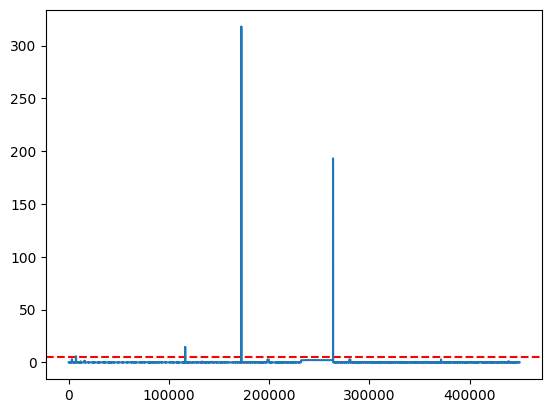

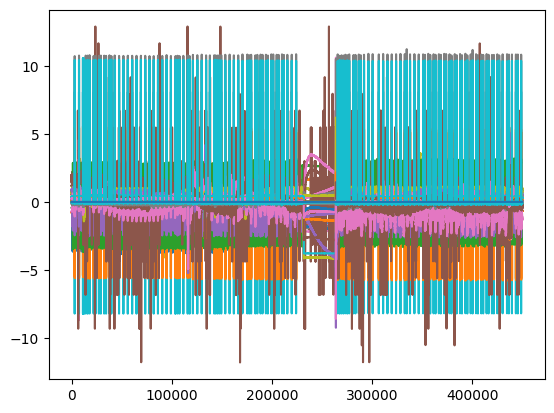

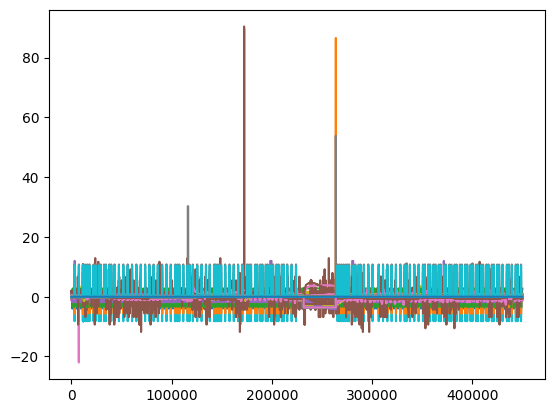

In [37]:
# compute the reconstructed test data
reconstructed_test_data = reconstruct_data(reduced_data, principal_components)
# compute the residuals on the test data
dist, rec_data, actual_vals, indices = residuals_and_anomalies_indices(filtered_test_data, reconstructed_test_data)
distance_plot(dist, rec_data, actual_vals)

In [38]:
# we thought that it would be a good idea to choose the final threshold for the test data using quantiles that is because we would like to consider as anomalies the values that are the highest, in this way by just changing the quantile we can have a better control over the amount of false positives and false negatives, we tried to ensure that the amount of false negatives is as low as possible.
threshold = np.quantile(dist, 0.9119) # best so far 0.9119 with k = 20 and threshold = 2.5
anomalies = []
cnt = 0
for i in range(len(dist)):
    if dist[i] > threshold:
        anomalies.append("Attack")
        cnt = cnt + 1
    else:
        anomalies.append("Normal")
print(cnt)
with open("submission.csv", "w") as f:
    f.write("Index,Label\n")
    for i in range(len(anomalies)):
        f.write(f'{i},{anomalies[i]}\n')

39638
